In [1]:
import dicom
import os
import numpy as np
import math
from matplotlib import pyplot as plt
from matplotlib import cm
from qstatistic.qstatistic import qSigmoid

In [2]:
# Load all images directories from a folder to a list.
def loadDirectories(PathDicom="./images/"):
    lstFilesDCM = []  # create an empty list
    for dirName, subdirList, fileList in os.walk(PathDicom):
        for filename in fileList:
            if ".dcm" in filename.lower():  # check whether the file's DICOM
                lstFilesDCM.append(os.path.join(dirName,filename))
                
    return lstFilesDCM

In [3]:
def normalize(v):
    norm=np.linalg.norm(v)
    if norm==0: 
       return v
    return v/norm

In [4]:
dicom_list = loadDirectories()
image_full = dicom.read_file(dicom_list[1])

image = image_full.pixel_array

lin, col = image.shape

L = np.max(image)
B = 1750
a = 130
q = 0.35

result = qSigmoid(L=L, I=image, B=B, a=a, q=q).calc()

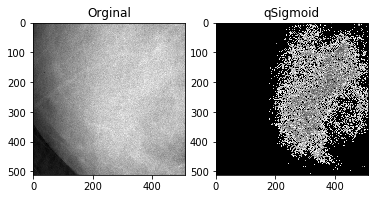

In [5]:
fig = plt.figure()

a = fig.add_subplot(1,2,1)
img_plot = plt.imshow(image, cmap=plt.cm.gray)
a.set_title('Orginal')
a = fig.add_subplot(1,2,2)
img_plot = plt.imshow(result, cmap=plt.cm.gray)
a.set_title('qSigmoid')
plt.show()